<a href="https://colab.research.google.com/github/rodrimdz/Hourly-Energy-Consumption/blob/gh-pages/HourlyEnergyConsumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hourly Energy Consumption

Over 10 years of hourly energy consumption data from PJM in Megawatts

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from datetime import datetime
import seaborn as sns

In [24]:
data=pd.read_csv("https://github.com/rodrimdz/Hourly-Energy-Consumption/blob/gh-pages/AEP_hourly.csv?raw=true")
data.iloc[::-1]
data.shape


(121273, 2)

**The dataset is imported, this is the raw data**

In [25]:
data.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


**A preliminary look about highlights of consumption energy**

In [26]:
data.describe()

,AEP_MW
count,121273.000000
mean,15499.513717
std,2591.399065
min,9581.000000
25%,13630.000000
50%,15310.000000
75%,17200.000000
max,25695.000000


**Date of highest consumption energy**

In [27]:
data[data["AEP_MW"] == data["AEP_MW"].max()]

,Datetime,AEP_MW
30221,2008-10-20 14:00:00,25695.0


**Date of lowest consumption energy**

In [28]:
data[data["AEP_MW"] == data["AEP_MW"].min()]

,Datetime,AEP_MW
100759,2016-10-02 05:00:00,9581.0


**How are the consumptions distributed? where are the consumptions that are repeated the most? here the answer:**

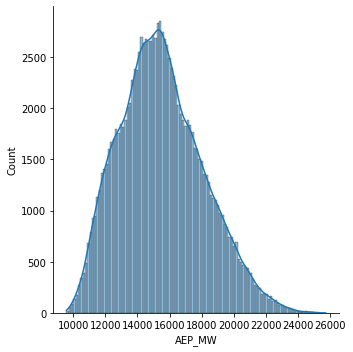

In [29]:
sns.displot(data=data, x=data["AEP_MW"], kde=True)

**I work a little with the data, hour, year and month are separated**

In [30]:
data["New_Date"] = pd.to_datetime(data["Datetime"]).dt.date
data["New_Time"] = pd.to_datetime(data["Datetime"]).dt.time
data["Time"]=data["New_Time"].astype("string")
times=data["Time"].str.split(":",1, expand = True)
data["Time"]=times[0]
data["Time"]=pd.to_numeric(data["Time"])
data["Year"] = pd.DatetimeIndex(data['New_Date']).year
data["Month"] = pd.DatetimeIndex(data['New_Date']).month
data.head()

,Datetime,AEP_MW,New_Date,New_Time,Time,Year,Month
0,2004-12-31 01:00:00,13478.0,2004-12-31,01:00:00,1,2004,12
1,2004-12-31 02:00:00,12865.0,2004-12-31,02:00:00,2,2004,12
2,2004-12-31 03:00:00,12577.0,2004-12-31,03:00:00,3,2004,12
3,2004-12-31 04:00:00,12517.0,2004-12-31,04:00:00,4,2004,12
4,2004-12-31 05:00:00,12670.0,2004-12-31,05:00:00,5,2004,12


**What is the relationship between the data, especially between consumption and hour, month, year?
It is observed that there is a certain level of correlation between time and consumption. 
This will be analyzed in detail later.**

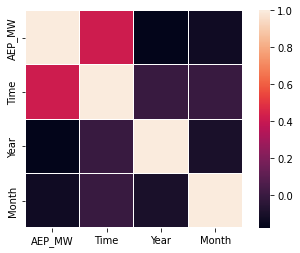

In [31]:
corr=data.corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr,square=True,linewidths=.1)

**Average consumption per year, a downward trend is observed.**
Note: Years 2004 and 2018 are not complete

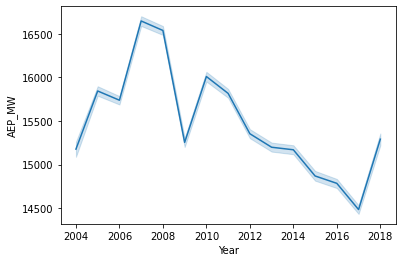

In [32]:
sns.lineplot(x=data["Year"],y=data["AEP_MW"], data=data)

**Average total consumption per month, changes are observed in the coldest and warmest months**

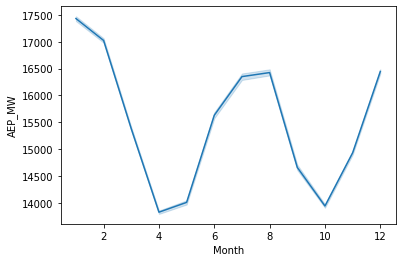

In [33]:
sns.lineplot(x=data["Month"],y=data["AEP_MW"])

**Average consumption per month, each graph corresponds to each year. The trend of high and low values is repeated every year.**

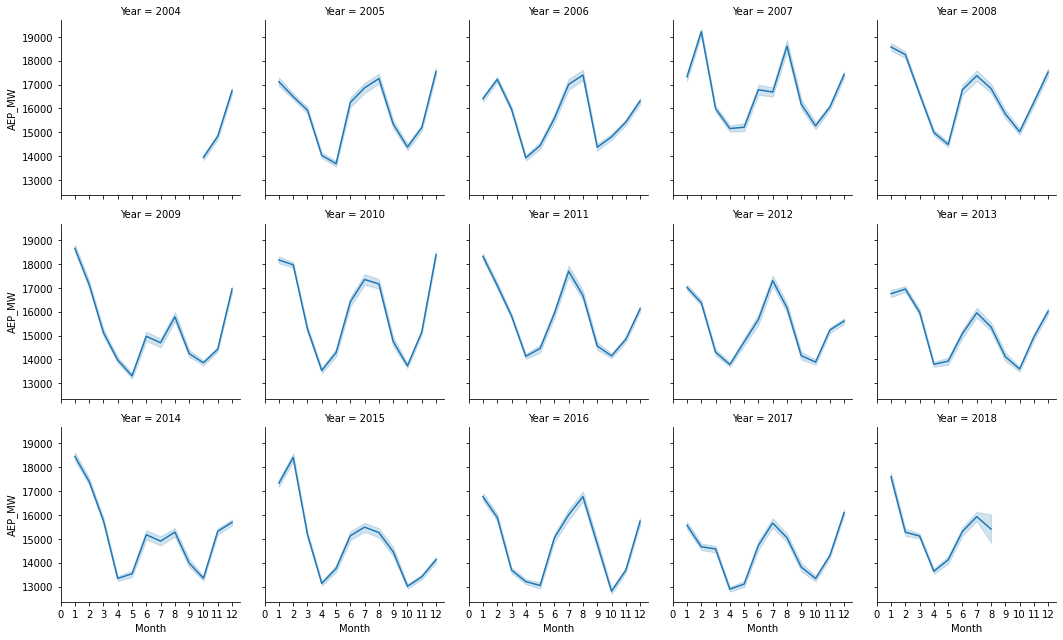

In [34]:
g=sns.relplot(x=data["Month"],y=data["AEP_MW"], col=data["Year"],kind="line",col_wrap=5, height=3)
g.set(xticks=[0,1,2,3,4,5,6,7,8,9,10,11,12])

**Average total consumption per hour. There is a downward trend in the night hours and an upward trend in the daytime hours. But, every month the same thing will happen? will there be a difference in winter months and summer months? Let's see**

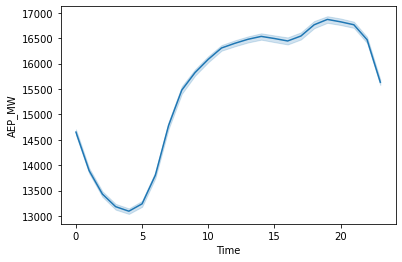

In [35]:
sns.lineplot(x=data["Time"],y=data["AEP_MW"])

**Average consumption per hour, for each month. Here we can see that the consumption changes a lot for each month, even the consumption trend changes in the same hour and different month.**

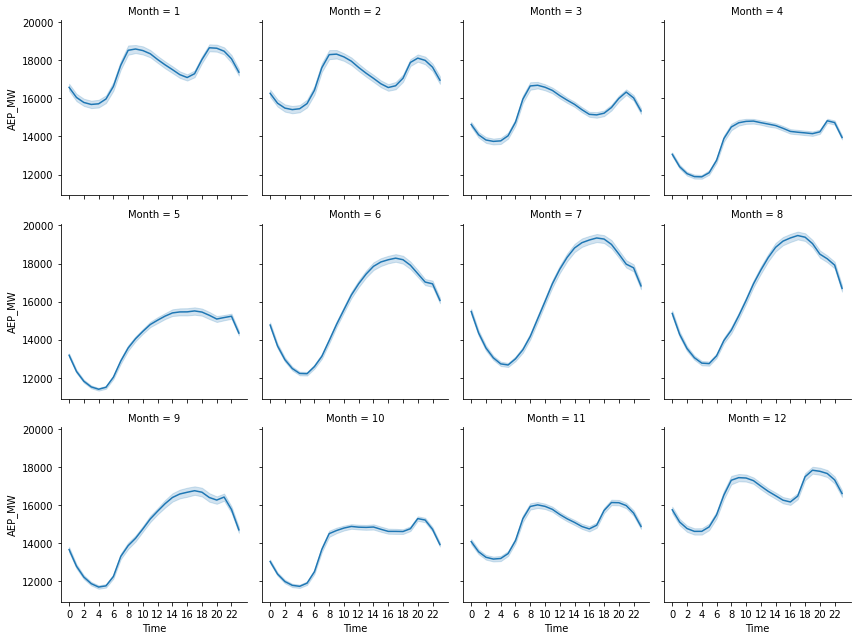

In [36]:
g=sns.relplot(x=data["Time"],y=data["AEP_MW"], col=data["Month"],kind="line",col_wrap=4, height=3)
g.set(xticks=[0,2,4,6,8,10,12,14,16,18,20,22])

**Here all the previous graphs in the same plot**

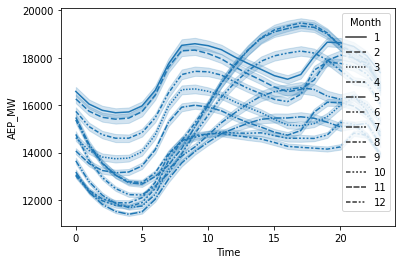

In [37]:
  sns.lineplot(x=data["Time"],y=data["AEP_MW"],style=data["Month"])

**Linear and polynomial regression applied to consumption per hour**

**The model is built**

In [94]:
time=data.groupby(["Time"]).mean()
time["Time"]=time.index
time=time.drop(columns=["Month","Year"])
x=time["Time"]
y=time["AEP_MW"]
x=x.values.reshape(-1,1)
lm=LinearRegression()
lm.fit(x,y)


LinearRegression()

**The linear model is applied, but it is not very representative. We can try to make a polynomial model.**

In [95]:
lm.score(x,y)

0.6772146586776093

**Graph of consumption per hour and our model, it is observed that it follows the trend but does not fit well.**

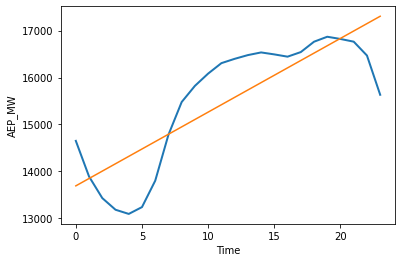

In [90]:
sns.lineplot(x=time["Time"],y=y, data=time, linewidth=2)
sns.lineplot(x=time["Time"],y=lm.predict(x))

In [91]:
def regresion_validation(x,y,y_pred):
    SSD=np.sum((y-lm.predict(x))**2)
    RSE=np.sqrt(SSD/(len(x)-1))
    y_mean=np.mean(y)
    error=RSE/y_mean
    print("Score: "+str(lm.score(x,y)))
    print("SSD: "+str(SSD)+", RSE: "+str(RSE)+", y_mean: "+str(y_mean)+", error: "+str(error*100)+"\n")

**The polynomial model of degree 1 to 5 is applied, the regression model of degree 5 is the one that best fits.**

Regression grade 1
Score: 0.6772146586776089
SSD: 13523082.835598724, RSE: 766.7855784291336, y_mean: 15499.125916017054, error: 4.947282721516086

Regression grade 2
Score: 0.7642869987637788
SSD: 9875189.586014472, RSE: 655.2526756581395, y_mean: 15499.125916017054, error: 4.227675026376749

Regression grade 3
Score: 0.8775519152808168
SSD: 5129959.080341484, RSE: 472.2729074860021, y_mean: 15499.125916017054, error: 3.047093817064532

Regression grade 4
Score: 0.9348741599265397
SSD: 2728445.24612948, RSE: 344.4242357609908, y_mean: 15499.125916017054, error: 2.22221716003389

Regression grade 5
Score: 0.978116699741088
SSD: 916800.251539235, RSE: 199.65189831731095, y_mean: 15499.125916017054, error: 1.288149405322189



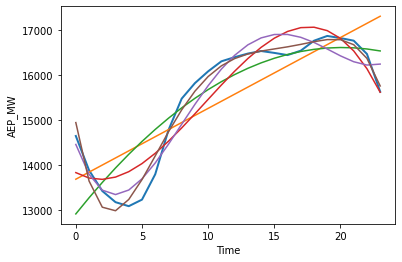

In [96]:
sns.lineplot(x=time["Time"],y=y, data=time, linewidth=2)
for d in range(1,6):
    poly =PolynomialFeatures(degree=d)
    xpoly=poly.fit_transform(x)
    lm=linear_model.LinearRegression()
    lm.fit(xpoly,y)
    print("Regression grade "+str(d))
    regresion_validation(xpoly,y,lm.predict(xpoly))
    
    sns.lineplot(x=time["Time"],y=lm.predict(poly.fit_transform(x)))

**Here only the graph of the grade 5 model, we see that it is very similar. Therefore, the built model fits well.**

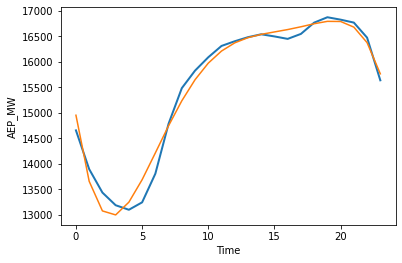

In [99]:
poly =PolynomialFeatures(5)
xpoly=poly.fit_transform(x)
lm=linear_model.LinearRegression()
lm.fit(xpoly,y)
sns.lineplot(x=time["Time"],y=y, data=time, linewidth=2)
sns.lineplot(x=time["Time"],y=lm.predict(poly.fit_transform(x)))